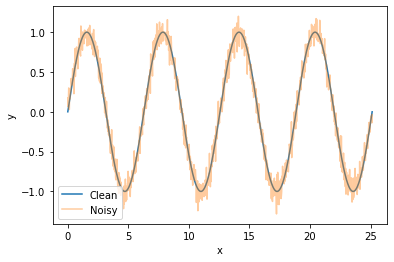

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(123)


# Define the range of x values
x = np.linspace(0, 8 * np.pi, 1000)

# Generate the clean sine wave
y_clean = np.sin(x)

# Generate white noise
noise = np.random.normal(0, 0.1, len(x))

# Add white noise to the clean sine wave
time_series = y_clean + noise

# Plot the clean and noisy sine wave
plt.plot(x, y_clean, label='Clean')
plt.plot(x, time_series, label='Noisy',alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [2]:
# Prepare the training data
x = torch.from_numpy(time_series[:-3]).float()
y = torch.from_numpy(time_series[5:]).float()

# Reshape the input data to have 3 values in each row
x = x.unfold(0, 3, 1).reshape(-1, 3).unsqueeze(2)


# Reshape the target data to match the size of the predicted tensor
y = y[3 - 1:].unsqueeze(1)

# Pad the target tensor with zeros to match the input size
target_padding = torch.zeros((len(x) - len(y), 1))
y = torch.cat((y, target_padding))
print(x.shape)
print(y.shape)


torch.Size([995, 3, 1])
torch.Size([995, 1])


In [3]:
import torch.nn as nn
from torch.nn import functional as F

class ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout_fn,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):
   
        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout_fn = dropout_fn
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = nn.utils.weight_norm(
                self.conv1
            ), nn.utils.weight_norm(self.conv2)

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        # first step
        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout_fn(F.relu(self.conv1(x)))

        # second step
        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout_fn(x)

        # add residual
        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x

class TCNModule(nn.Module):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: int,
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        dropout: float,
    ):

        super().__init__()

        # Defining parameters
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base
        self.dropout = nn.Dropout(p=dropout)

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = ResidualBlock(
                num_filters,
                kernel_size,
                dilation_base,
                self.dropout,
                weight_norm,
                i,
                num_layers,
                self.input_size,
                target_size * nr_params,
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    def forward(self, x_in):
        x = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, -1, self.target_size, self.nr_params
        )

        return x

In [4]:
# Define the TCN model
input_size = 1
kernel_size = 3
num_filters = 32
num_layers = 4
dilation_base = 2
weight_norm = False
target_size = 1
nr_params = 1
dropout = 0.2

tcn_model = TCNModule(
    input_size, kernel_size, num_filters, num_layers, dilation_base,
    weight_norm, target_size, nr_params, dropout
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = tcn_model(x)
    y_true = y.unsqueeze(1)   
    loss = criterion(outputs[:, -1, :, :], y_true)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate predictions for t+3
with torch.no_grad():
    predictions = tcn_model(x)
    print(predictions.shape)
    predicted = predictions[:, -1, 0]  # Extract the predicted values at t+3
    print(predicted.shape)

Epoch [100/1000], Loss: 0.0235
Epoch [200/1000], Loss: 0.0240
Epoch [300/1000], Loss: 0.0232
Epoch [400/1000], Loss: 0.0231
Epoch [500/1000], Loss: 0.0225
Epoch [600/1000], Loss: 0.0225
Epoch [700/1000], Loss: 0.0225
Epoch [800/1000], Loss: 0.0220
Epoch [900/1000], Loss: 0.0220
Epoch [1000/1000], Loss: 0.0224
torch.Size([995, 3, 1, 1])
torch.Size([995, 1])


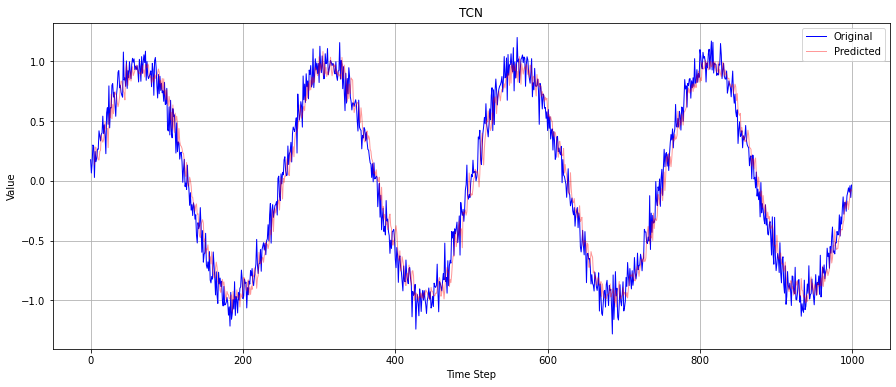

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(time_series, color='blue', label='Original', linewidth=1)
plt.plot(range(5, len(time_series)), predicted, color='red', label='Predicted', linewidth=1, alpha=0.4)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('TCN')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate MSE for each dimension
mse = torch.mean((predicted - y)**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(predicted - y), dim=0)
print("MSE,MAE for original predict")
print(mse)
print(mae)

MSE,MAE for original predict
tensor([0.0220])
tensor([0.1187])


torch.Size([995, 1, 1])
(995, 1)


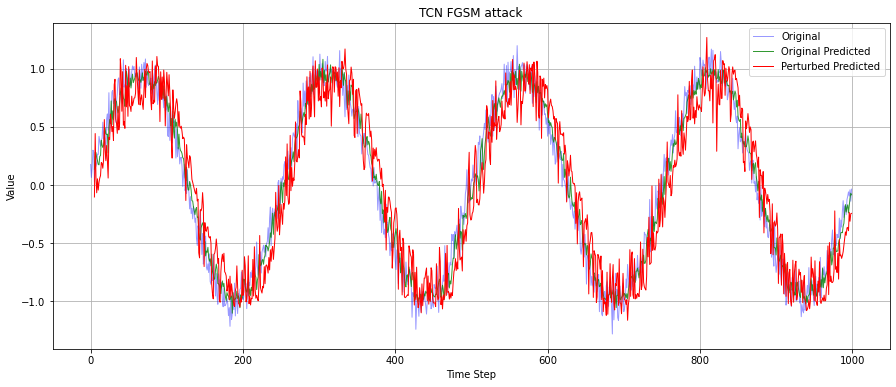

In [7]:
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data
x.requires_grad = True
outputs = tcn_model(x)    
y_true = y.unsqueeze(1)   
loss = criterion(outputs[:, -1, :, :], y_true)
print(outputs[:, -1, :, :].shape)
loss.backward(retain_graph=True)
data_grad = x.grad.data
perturbed_data = fgsm_attack(x, 0.2, data_grad)
# Generate predictions from the trained model with perturbed data
perturbed_predicted = tcn_model(perturbed_data).detach().numpy()
perturbed_predicted = perturbed_predicted[:, -1, 0]
print(perturbed_predicted.shape)
# Plot the original time series, original predictions, and perturbed predictions
plt.figure(figsize=(15,6))
plt.plot(time_series, color='blue', label='Original', linewidth=1,alpha=0.4)
#plt.plot(range(input_dim, len(time_series)), perturbed_data.detach().numpy()[:, 0], color='yellow', label='perturbed data', linewidth=1)
plt.plot(range(5, len(time_series)), predicted[:, 0], color='green', label='Original Predicted', linewidth=1,alpha=0.8)
plt.plot(range(5, len(time_series)), perturbed_predicted[:, 0], color='red', label='Perturbed Predicted', linewidth=1)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('TCN FGSM attack')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Calculate MSE for each dimension
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y)**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y), dim=0)
print("MSE,MAE for FGSM predict")
print(mse)
print(mae)

MSE,MAE for FGSM predict
tensor([0.0896])
tensor([0.2752])


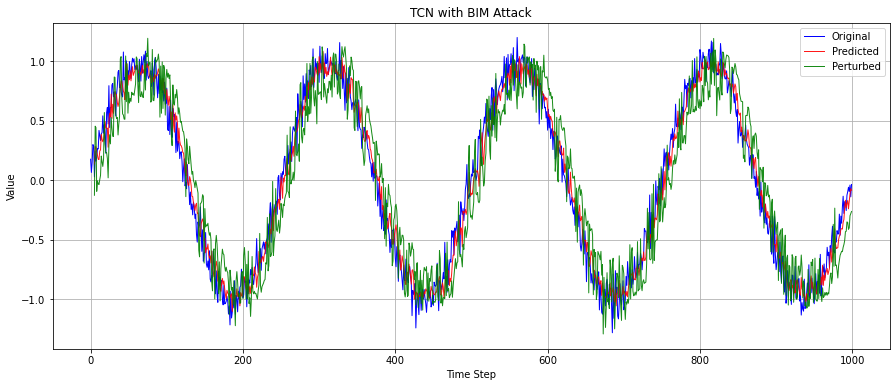

In [9]:

# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs[:, -1, :, :], Y.unsqueeze(1))
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data
# Perform BIM attack
perturbed_data = bim(x, y, tcn_model, epsilon=0.2, alpha=0.002, I=200)
# Generate predictions from the perturbed data
perturbed_x = perturbed_data.float()
perturbed_predicted = tcn_model(perturbed_x).detach().numpy()
perturbed_predicted = perturbed_predicted[:, -1, 0]
# Plot the original, predicted, and perturbed data
plt.figure(figsize=(15, 6))
plt.plot(time_series, color='blue', label='Original', linewidth=1)
plt.plot(range(5, len(time_series)), predicted, color='red', label='Predicted', linewidth=1, alpha=0.9)
plt.plot(range(5, len(time_series)), perturbed_predicted[:, 0], color='green', label='Perturbed', linewidth=1, alpha=0.9)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('TCN with BIM Attack')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Calculate MSE for each dimension
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y)**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y), dim=0)
print("MSE,MAE for BIM predict")
print(mse)
print(mae)

MSE,MAE for BIM predict
tensor([0.1004])
tensor([0.2983])
